In [1]:
import findspark

findspark.init()

In [155]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, udf, row_number
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder.getOrCreate()

In [165]:
import warnings
from warnings import catch_warnings
from warnings import filterwarnings

import pandas as pd
from pandas import Series
import datetime as dt
from datetime import timedelta

import math
from math import sqrt
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools

In [170]:
# Import Stock Price Data dataset

filepathname = "Data/TSLA_stockprice.csv"

stock_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(filepathname)

In [171]:
stock_data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)



In [172]:
stock_data.describe().show()

+-------+----------+-----------------+------------------+------------------+------------------+------------------+----------------+
|summary|      Date|             Open|              High|               Low|             Close|         Adj Close|          Volume|
+-------+----------+-----------------+------------------+------------------+------------------+------------------+----------------+
|  count|      1259|             1259|              1259|              1259|              1259|              1259|            1259|
|   mean|      null|276.2635346727561|281.13291495472595|271.45169172676793|276.52841173629815|276.52841173629815|7006977.60127085|
| stddev|      null|71.62431039849459| 74.67138746842221| 69.78160711970395| 72.41145695566233| 72.41145695566233|5147194.43771005|
|    min|2015-02-09|       142.320007|        154.970001|        141.050003|        143.669998|        143.669998|        10015400|
|    max|2020-02-07|       882.960022|        968.989990|        833.880005|

In [173]:
stock_data.cache()
stock_data.show(5)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2015-02-09|215.380005|217.929993|211.990005|217.479996|217.479996| 3472400|
|2015-02-10|217.550003|220.500000|215.000000|216.289993|216.289993| 5390500|
|2015-02-11|212.210007|214.740005|207.279999|212.800003|212.800003| 9769100|
|2015-02-12|193.570007|203.089996|193.279999|202.880005|202.880005|15649600|
|2015-02-13|202.899994|205.990005|200.910004|203.770004|203.770004| 6191000|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows



In [174]:
# Consider only the Adjusted Close

stock_data = stock_data.select('Date','Adj Close')

stock_data.cache()
stock_data.show(5)

+----------+----------+
|      Date| Adj Close|
+----------+----------+
|2015-02-09|217.479996|
|2015-02-10|216.289993|
|2015-02-11|212.800003|
|2015-02-12|202.880005|
|2015-02-13|203.770004|
+----------+----------+
only showing top 5 rows



In [79]:
# Filtering the DataFrame by Date: consider only the month of June

stock_filtered = stock_data.\
    filter(stock_data.Date.like("2019-06%")).\
    withColumn("Date", to_date(stock_data.Date)).\
    withColumn("Adj Close", stock_data["Adj Close"].cast(DoubleType()))

stock_filtered.cache()
stock_filtered.printSchema()
stock_filtered.show(5)

root
 |-- Date: date (nullable = true)
 |-- Adj Close: double (nullable = true)

+----------+----------+
|      Date| Adj Close|
+----------+----------+
|2019-06-03|178.970001|
|2019-06-04|193.600006|
|2019-06-05|196.589996|
|2019-06-06|205.949997|
|2019-06-07|     204.5|
+----------+----------+
only showing top 5 rows



In [36]:
# Import Tweets Sentiment Analysis dataset

filepathname = "Data/TSLA_sentiment.csv"

sent_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(filepathname)

In [37]:
sent_data.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- user.screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- text: string (nullable = true)
 |-- Polarity: string (nullable = true)
 |-- Subjectivity: string (nullable = true)



In [38]:
sent_data.cache()
sent_data.show(5)

+-----+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|  _c0|                 _id|user.screen_name|          created_at|        timestamp_ms|                text|            Polarity|       Subjectivity|
+-----+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|10834|ObjectId(5e411350...| TheDirtyBoogie1|Sun Jun 02 06:56:...|2019-06-02 06:56:...|@teslataxisea @Te...|                -0.5|                0.9|
|14825|ObjectId(5e411356...|       jwoods_57|Sun Jun 02 06:33:...|2019-06-02 06:33:...|@TeslaOpinion #Te...| 0.15416666666666667| 0.6666666666666666|
|27402|ObjectId(5e41136b...|   MarikoSanoUSA|Sun Jun 02 07:19:...|2019-06-02 07:19:...|RT @evannex_com: ...|-0.06666666666666667|0.45666666666666667|
|34273|ObjectId(5e411377...|    paradis_yves|Sun Jun 02 07:33:...|2019-06-02 07:33:...|RT @cleantech

In [39]:
sent_data = sent_data.\
    select('timestamp_ms','Polarity')

sent_data.cache()
sent_data.show(5)

+--------------------+--------------------+
|        timestamp_ms|            Polarity|
+--------------------+--------------------+
|2019-06-02 06:56:...|                -0.5|
|2019-06-02 06:33:...| 0.15416666666666667|
|2019-06-02 07:19:...|-0.06666666666666667|
|2019-06-02 07:33:...|                 0.0|
|2019-06-02 07:40:...|                 0.0|
+--------------------+--------------------+
only showing top 5 rows



In [52]:
# Filtering the DataFrame by Date: consider only the month of June

sent_filtered = sent_data.filter(sent_data.timestamp_ms.like("2019-06%")).\
    withColumn("Date", to_date(sent_data.timestamp_ms)).\
    withColumn("Polarity", sent_data.Polarity.cast(DoubleType())).\
    select('Date','Polarity')
    

sent_filtered.cache()
sent_filtered.show(5)
sent_filtered.printSchema()

+----------+--------------------+
|      Date|            Polarity|
+----------+--------------------+
|2019-06-02|                -0.5|
|2019-06-02| 0.15416666666666667|
|2019-06-02|-0.06666666666666667|
|2019-06-02|                 0.0|
|2019-06-02|                 0.0|
+----------+--------------------+
only showing top 5 rows

root
 |-- Date: date (nullable = true)
 |-- Polarity: double (nullable = true)



In [74]:
# Feature Engineering - Sentiment Data

def prod(x,y):
    return x*y
prod_udf = udf(prod, DoubleType())

sent_eng = sent_filtered.\
        groupby("Date").count().\
        withColumnRenamed("count","Volume").\
        join(sent_filtered.
            groupby("Date").avg("Polarity").\
            withColumnRenamed("avg(Polarity)","Polarity"), "Date").\
        select("Date", "Volume", "Polarity", prod_udf("Volume", "Polarity")).\
        withColumnRenamed("prod(Volume, Polarity)","WeightedSent").\
        sort("Date")
    
sent_eng.cache()
sent_eng.show()

+----------+------+--------------------+------------------+
|      Date|Volume|            Polarity|      WeightedSent|
+----------+------+--------------------+------------------+
|2019-06-02|   167|  0.0663165936167637|11.074871133999538|
|2019-06-03|   245| 0.09041759630553936|22.152311094857144|
|2019-06-04|   276|  0.1099959405473699|30.358879591074093|
|2019-06-05|   170| 0.06879164109108139|11.694578985483837|
|2019-06-06|   212| 0.12650453889211513|26.818962245128407|
|2019-06-07|   199| 0.10128098418987212| 20.15491585378455|
|2019-06-08|   138| 0.09999366134389716|13.799125265457809|
|2019-06-09|   128| 0.07020100789233441| 8.985729010218805|
|2019-06-10|   179| 0.11944648895125595|21.380921522274814|
|2019-06-11|   233| 0.11200009166607533|26.096021358195554|
|2019-06-12|   246|  0.1328141960277377| 32.67229222282347|
|2019-06-13|   252| 0.00803225074351835|2.0241271873666244|
|2019-06-14|   250| 0.03979616924811648|  9.94904231202912|
|2019-06-15|   187| 0.08479842972030473|

In [167]:
# JOIN THE DATAFRAMES

merged_dataframe = stock_filtered.\
    join(sent_eng, on = "Date", how = "outer").\
    sort("Date")

In [175]:
# CONVERT DATAFRAME INTO PANDAS FRAMEWORK

stock_data = stock_data.select("*").toPandas()
merged_dataframe = merged_dataframe.select("*").toPandas()

# Substitute the missing values in the weekend
for t in range(len(merged_dataframe)):
    if np.isnan(merged_dataframe['Adj Close'][t]):
        if t>0:
            merged_dataframe['Adj Close'][t] = merged_dataframe['Adj Close'][t-1]
        else:
            merged_dataframe['Adj Close'][t] = merged_dataframe['Adj Close'][t+1]

merged_dataframe.head()

,Date,Adj Close,Volume,Polarity,WeightedSent
0,2019-06-02,178.970001,167,0.066317,11.074871
1,2019-06-03,178.970001,245,0.090418,22.152311
2,2019-06-04,193.600006,276,0.109996,30.358880
3,2019-06-05,196.589996,170,0.068792,11.694579
4,2019-06-06,205.949997,212,0.126505,26.818962


# Time Series Visualization

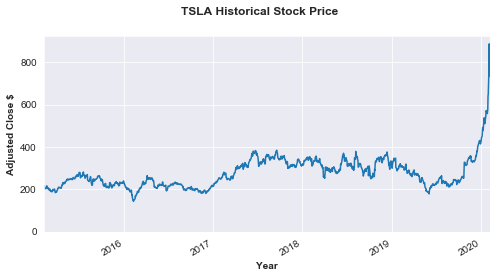

In [122]:
%matplotlib inline
sns.set_style("darkgrid")

months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  
years = mdates.YearLocator()
years_format = mdates.DateFormatter('%Y')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=stock_data, linestyle='-')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_format)


datemin = stock_data['Date'].iloc[0]
datemax = stock_data['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))
ax.set_ylim(0)

ax.format_xdata = mdates.DateFormatter('%m')

fig.autofmt_xdate()
fig.suptitle("TSLA Historical Stock Price", fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')


plt.savefig('TSLAwholeseries.png')
plt.show()

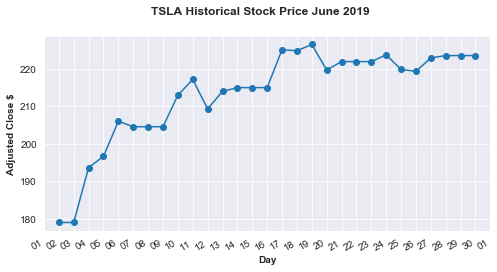

In [121]:
%matplotlib inline
sns.set_style("darkgrid")

days = mdates.DayLocator()
days_format = mdates.DateFormatter('%d')
months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=merged_dataframe, linestyle='-', marker='o')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)


datemin = merged_dataframe['Date'].iloc[0]
datemax = merged_dataframe['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))



ax.format_xdata = mdates.DateFormatter('%d-%m')

fig.autofmt_xdate()
fig.suptitle("TSLA Historical Stock Price June 2019", fontweight='bold')
ax.set_xlabel('Day', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')


plt.savefig('TSLAjune.png')
plt.show()

In [8]:
# Set the proportion of data for the training
train_size_prop = 0.66

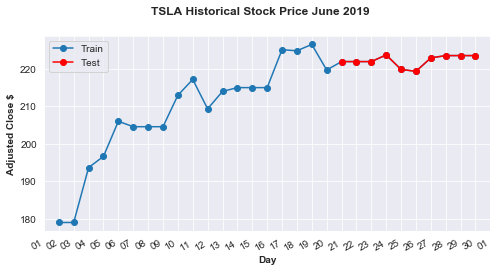

In [101]:
# TRAINSPLIT COLORS

%matplotlib inline
sns.set_style("darkgrid")

days = mdates.DayLocator()
days_format = mdates.DateFormatter('%d')
months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=merged_dataframe, linestyle='-', marker='o')
ax.plot('Date', 'Adj Close', data=merged_dataframe[int(train_size_prop*len(merged_dataframe)):]\
        , linestyle='-', marker='o',color='r')
ax.legend(['Train','Test'])

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)


datemin = merged_dataframe['Date'].iloc[0]
datemax = merged_dataframe['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))



ax.format_xdata = mdates.DateFormatter('%d-%m')

fig.autofmt_xdate()
fig.suptitle("TSLA Historical Stock Price June 2019", fontweight='bold')
ax.set_xlabel('Day', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')


plt.savefig('TSLAtraintest.png')
plt.show()


# Function definitions

In [15]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(X, train_size_prop):
    train_size = int(len(X) * train_size_prop)
    train, test = X[0:train_size], X[train_size:]
    return train, test

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#################################################################

def naive_model(X):
    # split dataset
    train, test = train_test_split(X, train_size_prop)

    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    predictions = list()
    for t in range(len(test)):
        #  make forecast for history
        yhat = history[-1]

        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[t])
        
    # estimate prediction error
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return predictions, mse, mape

#################################################################

# evaluate an ARIMA model for a given order (p,d,q)
# Put the "I" part only if there's a trend and in order to make the time series stationary
def arima_model(X, train_size_prop, cfg):
    # data type conversion to float32
    X = X.astype('float32')
    # split dataset
    train, test = train_test_split(X, train_size_prop)

    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    predictions = list()
    for t in range(len(test)):
        # fit model and make forecast for history
        model = ARIMA(history, order=cfg)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]

        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[t])
    
    # estimate prediction error
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return predictions, mse, mape

# evaluate combinations of p, d and q values for an ARIMA model
def grid_search_arima(dataset, train_size_prop, p_values, d_values, q_values):
    # data type conversion to float32
    dataset = dataset.astype('float32')
    
    # Initialize variables
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                cfg = (p,d,q)
                try:
                    # never show warnings when grid searching, too noisy
                    with catch_warnings():
                        filterwarnings("ignore")
                        pred, mse, mape = arima_model(dataset, train_size_prop, cfg)
                    
                    if mse < best_score:
                        best_score, best_cfg = mse, cfg
                    
                except:
                    continue
    print('Best MODEL[%s] MSE=%.3f' % (str(best_cfg), best_score))
    return best_cfg, best_score


In [16]:
def sarima_model(X, exog_input, train_size_prop, cfg):
    # unpack cfg
    order, sorder, trend = cfg
    # data type conversion to float32
    X = X.astype('float32')
    # split dataset
    train, test = train_test_split(X, train_size_prop)
    
    # seed history with training dataset
    history = [x for x in train]
    # see history also for the exogenous inputs
    if len(exog_input)!=0:
        train_ei, test_ei = train_test_split(exog_input, train_size_prop)
        history_ei =  [x for x in train_ei]
    else:
        history_ei = []
        
    # step over each time-step in the test set
    predictions = list()
    for t in range(len(test)):
        # define model
        if len(exog_input)!=0:            
            model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, exog=history_ei, enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
        # fit model
        model_fit = model.fit(disp=False)
        # make one step forecast
        if len(exog_input)!=0:
            yhat = model_fit.predict(start=len(history), end=+len(history)+len(test)-1, \
                                 exog = np.array(test_ei).reshape(-1, 1))[0]
        else:
            yhat = model_fit.predict(len(history), len(history))[0]
        
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[t])
        
        if len(exog_input)!=0:
            history_ei.append(test_ei[t])
        
    # estimate prediction error
    mse = mean_squared_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return predictions, mse, mape
 
# grid search configs
def grid_search_sarima(dataset, exog_input, train_size_prop, p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    # data type conversion to float32
    dataset = dataset.astype('float32')
    
    # Initialize variables
    best_score, best_cfg = float("inf"), None
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), (t)]
    
                                    try:
                                        # never show warnings when grid searching, too noisy
                                        with catch_warnings():
                                            filterwarnings("ignore")
                                            pred, mse, mape = sarima_model(dataset, exog_input, train_size_prop, cfg)
                                
                                        if mse < best_score:
                                            best_score, best_cfg = mse, cfg
                                            
                                    except:
                                        continue
    print('Best MODEL[%s] MSE=%.3f' % (str(best_cfg), best_score))
    return best_cfg, best_score

# Naive Model (Adj Close)

In [27]:
X = merged_dataframe['Adj Close'].values

pred_naive, mse_naive, mape_naive = naive_model(X)
print('Test MSE: %.3f' % mse_naive)
print('Test MAPE: %.3f' % mape_naive)

Test MSE: 11.855
Test MAPE: 1.254


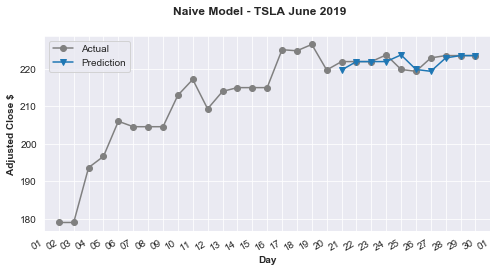

In [120]:
X = merged_dataframe['Adj Close'].values
train, test = train_test_split(X,train_size_prop)

%matplotlib inline
sns.set_style("darkgrid")

days = mdates.DayLocator()
days_format = mdates.DateFormatter('%d')
months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=merged_dataframe, linestyle='-', marker='o', color='grey')
ax.plot(merged_dataframe['Date'], [None for x in train] + [x for x in pred_naive], linestyle='-', marker='v')
ax.legend(['Actual','Prediction'])

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)


datemin = merged_dataframe['Date'].iloc[0]
datemax = merged_dataframe['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))



ax.format_xdata = mdates.DateFormatter('%d-%m')

fig.autofmt_xdate()
fig.suptitle("Naive Model - TSLA June 2019", fontweight='bold')
ax.set_xlabel('Day', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')



plt.savefig('TSLAnaive.png')
plt.show()


# ARIMA Model (Adj Close)

In [31]:
X = merged_dataframe['Adj Close'].values

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# grid search arima hyperparameters
best_cfg_arima, best_score_arima = grid_search_arima(X, train_size_prop, p_values, d_values, q_values)

Best MODEL[(1, 0, 0)] MSE=11.636


In [29]:
# RECOMPUTE THE PREDICTIONS
pred_arima, mse_arima, mape_arima = arima_model(X, train_size_prop, best_cfg_arima)

print('Test MSE: %.3f' % mse_arima)
print('Test MAPE: %.3f' % mape_arima)

Test MSE: 11.636
Test MAPE: 1.142


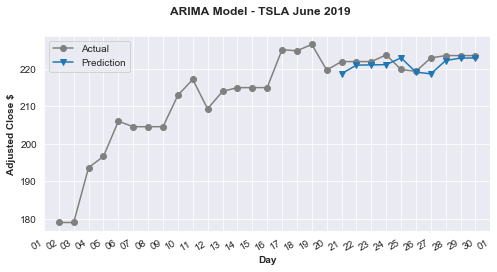

In [119]:
X = merged_dataframe['Adj Close'].values
train, test = train_test_split(X,train_size_prop)

%matplotlib inline
sns.set_style("darkgrid")

days = mdates.DayLocator()
days_format = mdates.DateFormatter('%d')
months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=merged_dataframe, linestyle='-', marker='o', color='grey')
ax.plot(merged_dataframe['Date'], [None for x in train] + [x for x in pred_arima], linestyle='-', marker='v')
ax.legend(['Actual','Prediction'])

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)


datemin = merged_dataframe['Date'].iloc[0]
datemax = merged_dataframe['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))



ax.format_xdata = mdates.DateFormatter('%d-%m')

fig.autofmt_xdate()
fig.suptitle("ARIMA Model - TSLA June 2019", fontweight='bold')
ax.set_xlabel('Day', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')



plt.savefig('TSLAarima.png')
plt.show()


# SARIMA Model (Adj Close)

In [32]:
X = merged_dataframe['Adj Close'].values
exog_input = []

# model configs
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [0,5] # no seasonality, every week

# grid search sarima hyperparameters
best_cfg_sarima, best_score_sarima = grid_search_sarima(X, exog_input, train_size_prop, p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params)


Best MODEL[[(1, 0, 1), (0, 0, 1, 0), 'c']] MSE=5.229


In [34]:
# RECOMPUTE THE PREDICTIONS

exog_input = []

pred_sarima, mse_sarima, mape_sarima = sarima_model(X, exog_input, train_size_prop, best_cfg_sarima)

print('Test MSE: %.3f' % mse_sarima)
print('Test MAPE: %.3f' % mape_sarima)

Test MSE: 5.229
Test MAPE: 0.987


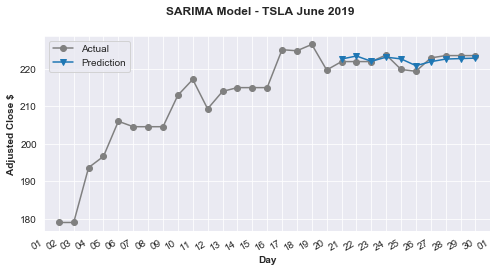

In [118]:
X = merged_dataframe['Adj Close'].values
train, test = train_test_split(X,train_size_prop)

%matplotlib inline
sns.set_style("darkgrid")

days = mdates.DayLocator()
days_format = mdates.DateFormatter('%d')
months = mdates.MonthLocator()
months_format = mdates.DateFormatter('%m')  

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot('Date', 'Adj Close', data=merged_dataframe, linestyle='-', marker='o', color='grey')
ax.plot(merged_dataframe['Date'], [None for x in train] + [x for x in pred_sarima], linestyle='-', marker='v')
ax.legend(['Actual','Prediction'])

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_format)


datemin = merged_dataframe['Date'].iloc[0]
datemax = merged_dataframe['Date'].iloc[-1]
ax.set_xlim(datemin+dt.timedelta(days=-1), datemax+dt.timedelta(days=1))


ax.format_xdata = mdates.DateFormatter('%d-%m')

fig.autofmt_xdate()
fig.suptitle("SARIMA Model - TSLA June 2019", fontweight='bold')
ax.set_xlabel('Day', fontweight='bold')
ax.set_ylabel('Adjusted Close $', fontweight='bold')


plt.savefig('TSLAsarima.png')
plt.show()


# SARIMAX

In [126]:
from scipy.stats import pearsonr

corr, _ = pearsonr(merged_dataframe['Adj Close'].values, merged_dataframe['Polarity'].values)
print("Correlation with Polarty: ", corr)
corr, _ = pearsonr(merged_dataframe['Adj Close'].values, merged_dataframe['WeightedSent'].values)
print("Correlation with WeightedSent: ", corr)

Correlation with Polarty:  -0.05004057935834592
Correlation with WeightedSent:  -0.17495663684951687
